In [1]:
import numpy as np
import torch
from numpy.testing import assert_almost_equal, assert_array_almost_equal

from pism_emulator.models.debm import DEBMModel

In [2]:
debm = DEBMModel()

In [3]:
    eccentricity = np.array([0.0167, 0.03])
    obliquity = np.deg2rad(np.array([23.14, 22.10]))
    perihelion_longitude = np.deg2rad(np.array([102.94719, -44.3]))
    debm = DEBMModel()
    d = debm.distance_factor_paleo(eccentricity, perihelion_longitude, obliquity)


In [4]:
    solar_constant = np.array([1361.0])
    distance_factor = np.array([1.1])
    hour_angle = np.array([0.8])
    latitude = np.array([np.pi / 4])
    declination = np.array([np.pi / 8])

    debm = DEBMModel()
    insolation = debm.insolation(solar_constant, distance_factor, hour_angle, latitude, declination)


In [5]:
time = np.array([2022.25])
debm = DEBMModel()
debm.orbital_parameters(time)

(array([0.083785]), array([1.000671]))

In [6]:
debm = DEBMModel(paleo_enabled=True)
debm.orbital_parameters(time)

(array([0.07843061]), array([0.99889585]))

In [7]:
debm = DEBMModel()
elevation = np.array([0.0, 1000.0, 2000.0])
transmissivity = debm.atmosphere_transmissivity(elevation)


In [8]:
transmissivity

array([0.65 , 0.682, 0.714])

In [9]:
melt_rate = np.array([1.])
debm = DEBMModel()
albedo = debm.albedo(melt_rate)


In [10]:
albedo

array([0.47])

In [11]:
#    pism_config:surface.debm_simple.albedo_slope_units = "m2 s kg-1";


In [12]:

import numpy as np
import torch
from numpy.testing import assert_array_almost_equal
import xarray as xr

from pism_emulator.models.pdd import ReferencePDDModel, TorchPDDModel


def make_fake_climate() -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Make fake climate to test surface models
    """

    temp = np.array(
        [
            [-3.12],
            [-2.41],
            [-0.62],
            [1.93],
            [4.41],
            [6.20],
            [6.91],
            [6.21],
            [4.40],
            [1.92],
            [-0.61],
            [-2.41],
        ],
    )
    precip = np.array(
        [
            [1.58],
            [1.47],
            [1.18],
            [0.79],
            [0.39],
            [0.11],
            [-0.01],
            [0.10],
            [0.39],
            [0.79],
            [1.18],
            [1.47],
        ],
        dtype=np.float64,
    )
    sd = np.array(
        [
            [0.0],
            [0.18],
            [0.70],
            [1.40],
            [2.11],
            [2.61],
            [2.81],
            [2.61],
            [2.10],
            [1.40],
            [0.72],
            [0.18],
        ],
    )
    return temp, precip, sd


def make_fake_climate_2d(filename=None):
    """Create an artificial temperature and precipitation file.

    This function is used if pypdd.py is called as a script without an input
    file. The file produced contains an idealized, three-dimensional (t, x, y)
    distribution of near-surface air temperature, precipitation rate and
    standard deviation of near-surface air temperature to be read by
    `PDDModel.nco`.

    filename: str, optional
        Name of output file.
    """

    ATTRIBUTES = {

        # coordinate variables
        'x': {
            'axis': 'X',
            'long_name': 'x-coordinate in Cartesian system',
            'standard_name': 'projection_x_coordinate',
            'units': 'm'},
        'y': {
            'axis': 'Y',
            'long_name': 'y-coordinate in Cartesian system',
            'standard_name': 'projection_y_coordinate',
            'units': 'm'},
        'time': {
            'axis': 'T',
            'long_name': 'time',
            'standard_name': 'time',
            'bounds': 'time_bounds',
            'units': 'yr'},
        'time_bounds': {},

        # climatic variables
        'temp': {
            'long_name': 'near-surface air temperature',
            'units':     'degC'},
        'prec': {
            'long_name': 'ice-equivalent precipitation rate',
            'units':     'm yr-1'},
        'stdv': {
            'long_name': 'standard deviation of near-surface air temperature',
            'units':     'K'},

        # cumulative quantities
        'smb': {
            'standard_name': 'land_ice_surface_specific_mass_balance',
            'long_name': 'cumulative ice-equivalent surface mass balance',
            'units':     'm yr-1'},
        'pdd': {
            'long_name': 'cumulative number of positive degree days',
            'units':     'degC day'},
        'accu': {
            'long_name': 'cumulative ice-equivalent surface accumulation',
            'units':     'm'},
        'snow_melt': {
            'long_name': 'cumulative ice-equivalent surface melt of snow',
            'units':     'm'},
        'ice_melt': {
            'long_name': 'cumulative ice-equivalent surface melt of ice',
            'units':     'm'},
        'melt': {
            'long_name': 'cumulative ice-equivalent surface melt',
            'units':     'm'},
        'runoff': {
            'long_name': 'cumulative ice-equivalent surface meltwater runoff',
            'units':     'm yr-1'},

        # instantaneous quantities
        'inst_pdd': {
            'long_name': 'instantaneous positive degree days',
            'units':     'degC day'},
        'accu_rate': {
            'long_name': 'instantaneous ice-equivalent surface accumulation rate',
            'units':     'm yr-1'},
        'snow_melt_rate': {
            'long_name': 'instantaneous ice-equivalent surface melt rate of snow',
            'units':     'm yr-1'},
        'ice_melt_rate': {
            'long_name': 'instantaneous ice-equivalent surface melt rate of ice',
            'units':     'm yr-1'},
        'melt_rate': {
            'long_name': 'instantaneous ice-equivalent surface melt rate',
            'units':     'm yr-1'},
        'runoff_rate': {
            'long_name': 'instantaneous ice-equivalent surface runoff rate',
            'units':     'm yr-1'},
        'inst_smb': {
            'long_name': 'instantaneous ice-equivalent surface mass balance',
            'units':     'm yr-1'},
        'snow_depth': {
            'long_name': 'depth of snow cover',
            'units':     'm'}}

    # FIXME code could be simplified a lot more but we need a better test not
    # relying on exact reproducibility of this toy climate data.

    # assign coordinate values
    lx = ly = 750000
    x = xr.DataArray(np.linspace(-lx, lx, 201, dtype='f4'), dims='x')
    y = xr.DataArray(np.linspace(-ly, ly, 201, dtype='f4'), dims='y')
    time = xr.DataArray((np.arange(12, dtype='f4')+0.5) / 12, dims='time')
    tboundsvar = np.empty((12, 2), dtype='f4')
    tboundsvar[:, 0] = time[:] - 1.0/24
    tboundsvar[:, 1] = time[:] + 1.0/24

    # seasonality index from winter to summer
    season = xr.DataArray(-np.cos(np.arange(12)*2*np.pi/12), dims='time')

    # order of operation is dictated by test md5sum and legacy f4 dtype
    temp = 5 * season - 10 * x / lx + 0 * y
    prec = y / ly * (season.astype('f4') + 0 * x + np.sign(y))
    stdv = (2+y/ly-x/lx) * (1+season)

    # this is also why transpose is needed here, and final type conversion
    temp = temp.transpose('time', 'x', 'y').astype('f4')
    prec = prec.transpose('time', 'x', 'y').astype('f4')
    stdv = stdv.transpose('time', 'x', 'y').astype('f4')

    # assign variable attributes
    temp.attrs.update(ATTRIBUTES['temp'])
    prec.attrs.update(ATTRIBUTES['prec'])
    stdv.attrs.update(ATTRIBUTES['stdv'])

    # make a dataset
    ds = xr.Dataset(
        data_vars={'temp': temp, 'prec': prec, 'stdv': stdv},
        coords={
            'time': time, 'x': x, 'y': y,
            'time_bounds': (['time', 'nv'], tboundsvar[:]),
        },
    )

    # write dataset to file
    if filename is not None:
        ds.to_netcdf(filename)

    # return dataset
    return ds

def test_torch_model():
    """
    Test the TorchPDDModel by comparing it to the ReferencePDDModel
    """
    temp, precip, sd = make_fake_climate()

    pdd_ref = ReferencePDDModel(
        pdd_factor_snow=0.003,
        pdd_factor_ice=0.008,
        refreeze_snow=0.6,
        refreeze_ice=0.1,
        temp_snow=0.0,
        temp_rain=2.0,
        interpolate_rule="linear",
        interpolate_n=52,
    )
    result_ref = pdd_ref(temp, precip, sd)

    pdd_torch = TorchPDDModel(
        pdd_factor_snow=3.0,
        pdd_factor_ice=8.0,
        refreeze_snow=0.6,
        refreeze_ice=0.1,
        temp_snow=0.0,
        temp_rain=2.0,
        interpolate_rule="linear",
        interpolate_n=52,
    )
    result_torch = pdd_torch.forward(temp, precip, sd)

    for m_var in [
        "temp",
        "prec",
        "accumulation_rate",
        "inst_pdd",
        "snow_depth",
        "snow_melt_rate",
        "ice_melt_rate",
        "melt_rate",
        "smb",
    ]:
        print(f"Comparing Reference and Torch implementation for variable {m_var}")
        assert_array_almost_equal(result_ref[m_var], result_torch[m_var], decimal=3)

def test_torch_model_2d():
    """
    Test the TorchPDDModel by comparing it to the ReferencePDDModel
    """
    ds = make_fake_climate_2d()
    
    temp = ds["temp"].to_numpy()
    precip = ds["prec"].to_numpy()
    sd = ds["stdv"].to_numpy()

    pdd_ref = ReferencePDDModel(
        pdd_factor_snow=0.003,
        pdd_factor_ice=0.008,
        refreeze_snow=0.6,
        refreeze_ice=0.1,
        temp_snow=0.0,
        temp_rain=2.0,
        interpolate_rule="linear",
        interpolate_n=52,
    )
    result_ref = pdd_ref(temp, precip, sd)

    pdd_torch = TorchPDDModel(
        pdd_factor_snow=3.0,
        pdd_factor_ice=8.0,
        refreeze_snow=0.6,
        refreeze_ice=0.1,
        temp_snow=0.0,
        temp_rain=2.0,
        interpolate_rule="linear",
        interpolate_n=52,
    )
    result_torch = pdd_torch.forward(temp, precip, sd)

    for m_var in [
        "temp",
        "prec",
        "accumulation_rate",
        "inst_pdd",
        "snow_depth",
        "snow_melt_rate",
        "ice_melt_rate",
        "melt_rate",
        "smb",
    ]:
        print(f"Comparing Reference and Torch implementation for variable {m_var}")
        assert_array_almost_equal(result_ref[m_var], result_torch[m_var], decimal=3)



In [13]:
    ds = make_fake_climate_2d()
    
    temp = ds["temp"].to_numpy()
    temp_K = ds["temp"].to_numpy() + 273.15
    precip = ds["prec"].to_numpy()
    sd = ds["stdv"].to_numpy()

    pdd_ref = ReferencePDDModel(
        pdd_factor_snow=0.003,
        pdd_factor_ice=0.008,
        refreeze_snow=0.6,
        refreeze_ice=0.1,
        temp_snow=0.0,
        temp_rain=2.0,
        interpolate_rule="linear",
        interpolate_n=52,
    )
    result_ref = pdd_ref(temp, precip, sd)

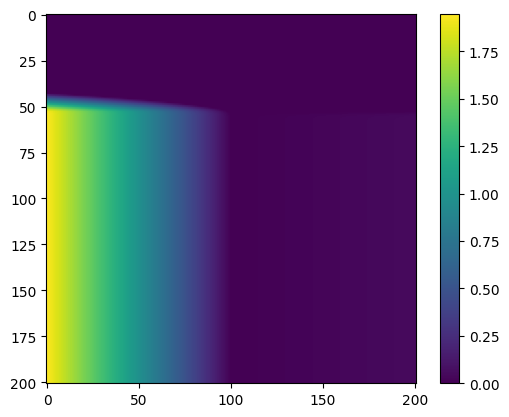

In [14]:
import pylab as plt

plt.imshow(result_ref["snow_depth"][0])
plt.colorbar()

In [15]:
debm = DEBMModel()
surface_elevation = np.zeros_like(temp) + 10
latitude = np.zeros_like(temp) 
albedo = np.zeros_like(temp) + 0.47
temp

array([[[  5.       ,   5.       ,   5.       , ...,   5.       ,
           5.       ,   5.       ],
        [  4.9      ,   4.9      ,   4.9      , ...,   4.9      ,
           4.9      ,   4.9      ],
        [  4.8      ,   4.8      ,   4.8      , ...,   4.8      ,
           4.8      ,   4.8      ],
        ...,
        [-14.8      , -14.8      , -14.8      , ..., -14.8      ,
         -14.8      , -14.8      ],
        [-14.9      , -14.9      , -14.9      , ..., -14.9      ,
         -14.9      , -14.9      ],
        [-15.       , -15.       , -15.       , ..., -15.       ,
         -15.       , -15.       ]],

       [[  5.6698728,   5.6698728,   5.6698728, ...,   5.6698728,
           5.6698728,   5.6698728],
        [  5.569873 ,   5.569873 ,   5.569873 , ...,   5.569873 ,
           5.569873 ,   5.569873 ],
        [  5.469873 ,   5.469873 ,   5.469873 , ...,   5.469873 ,
           5.469873 ,   5.469873 ],
        ...,
        [-14.130127 , -14.130127 , -14.130127 , ..., -

In [16]:
result_debm = debm(temp_K, sd, precip, surface_elevation, latitude)

/home/andy/base/pism-emulator/pism_emulator/models/debm.py:705: RuntimeWarning: divide by zero encountered in divide
  Z = temperature / (np.sqrt(2.0) * sigma)


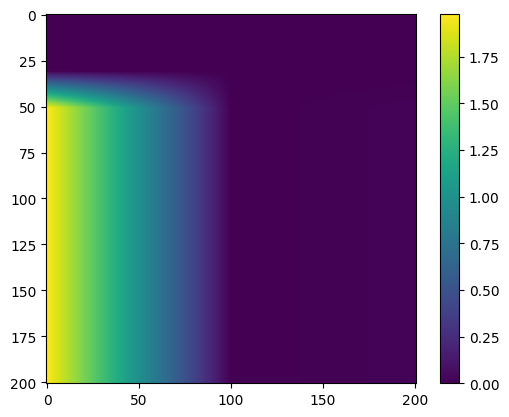

In [17]:
plt.imshow(result_debm["snow_depth"][0])
plt.colorbar()

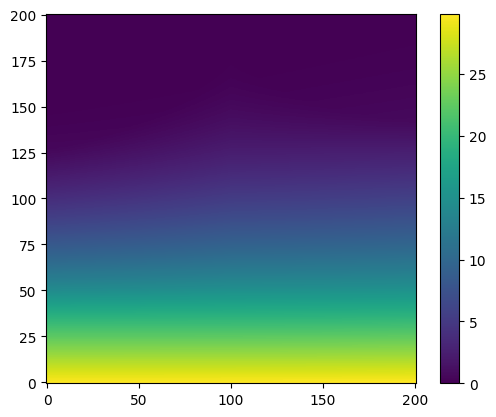

In [18]:
plt.imshow(result_ref["melt"], origin="lower")
plt.colorbar()

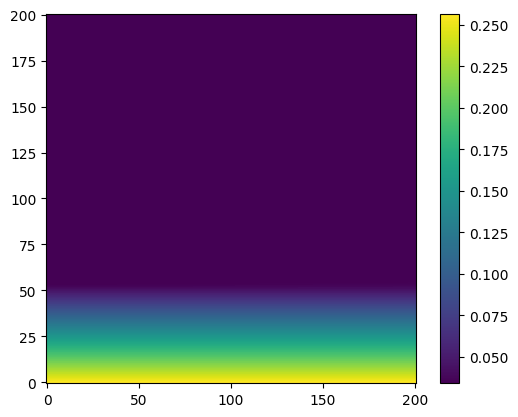

In [19]:
plt.imshow(result_debm["melt"] * debm.seconds_per_year() * 52, origin="lower")
plt.colorbar()

In [20]:
i = 0
year_fraction=1/12 * i
dt = 1/12
melt_info = debm.melt(temp[i], sd[i], albedo[i], surface_elevation[i], latitude[i], year_fraction, dt)

0.7743009128019438

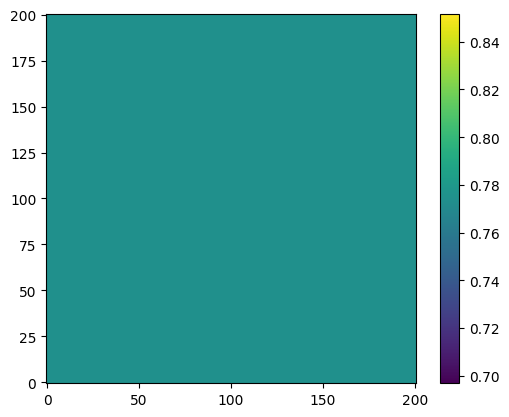

In [21]:
plt.imshow(melt_info["total_melt"] * debm.seconds_per_year(), origin="lower")
plt.colorbar()
melt_info["total_melt"].max() * debm.seconds_per_year()

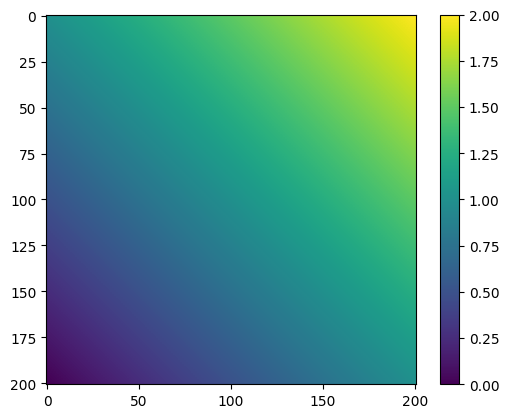

In [22]:
plt.imshow(sd[10])
plt.colorbar()

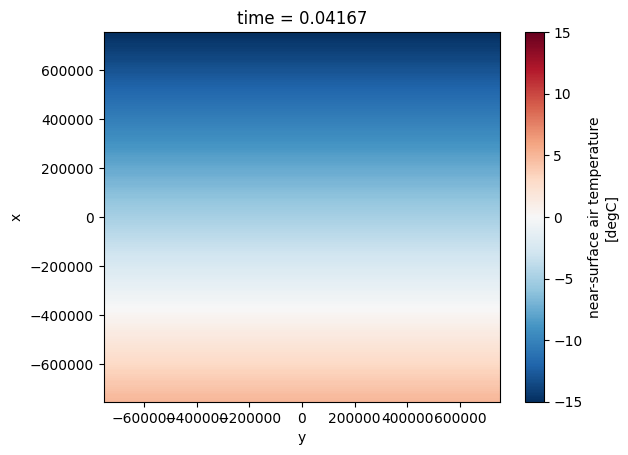

In [23]:
ds["temp"].isel(time=0).plot()

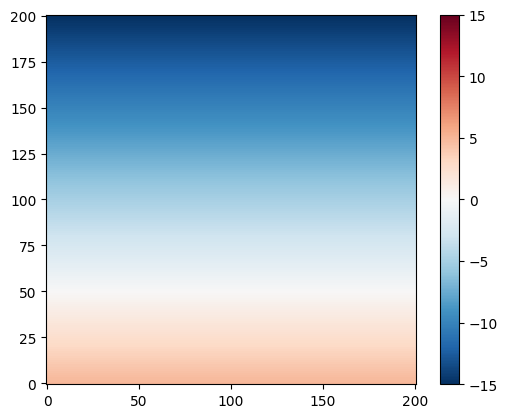

In [24]:
plt.imshow(temp[0], vmin=-15, vmax=15, origin="lower", cmap="RdBu_r")
plt.colorbar()

In [25]:
year_fraction = 0
dt = 1/ 12
temp = 323.0
temp_sd = 12.0
s = 1000
lat = np.pi/4 * 3
albedo = 0.47
melt_info = debm.melt(temp, temp_sd, albedo, s, lat, year_fraction, dt)


In [26]:
melt_info

{'insolation_melt': 3.425618349218347e-08,
 'temperature_melt': 1.3995243305283176e-07,
 'offset_melt': -9.003261572844215e-09,
 'total_melt': 1.6520535497217102e-07}

In [27]:
debm.CalovGreveIntegrand(temp_sd, temp_sd - debm.positive_threshold_temp)

array(6.8828277e-103)

In [28]:
    year_fraction = 0
    dt = 1/ 12
    temp = 323.0
    temp_sd = 12.0
    surface_elevation = 1000
    latitude = np.pi/4 * 3
    albedo = 0.47
    melt_info = debm.melt(temp, temp_sd, albedo, surface_elevation, latitude, year_fraction, dt)
    


In [29]:
melt_info

{'insolation_melt': 3.425618349218347e-08,
 'temperature_melt': 1.3995243305283176e-07,
 'offset_melt': -9.003261572844215e-09,
 'total_melt': 1.6520535497217102e-07}

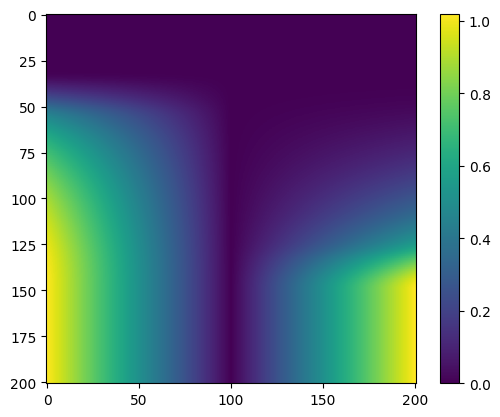

In [30]:
plt.imshow(result_ref["accumulation"])
plt.colorbar()

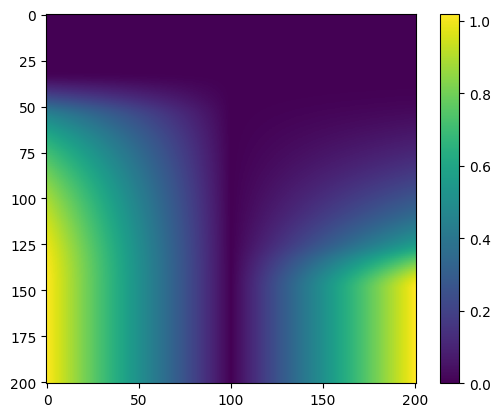

In [31]:
plt.imshow(result_debm["accumulation"])
plt.colorbar()

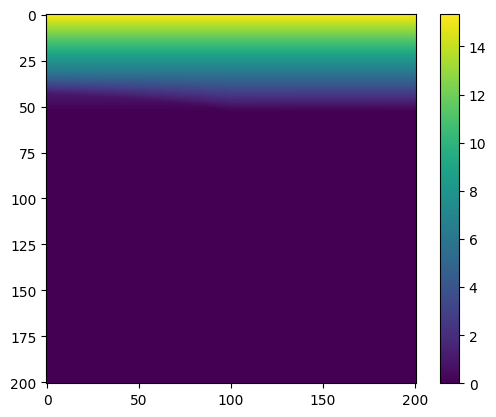

In [32]:
plt.imshow(result_ref["melt_rate"][0])
plt.colorbar()

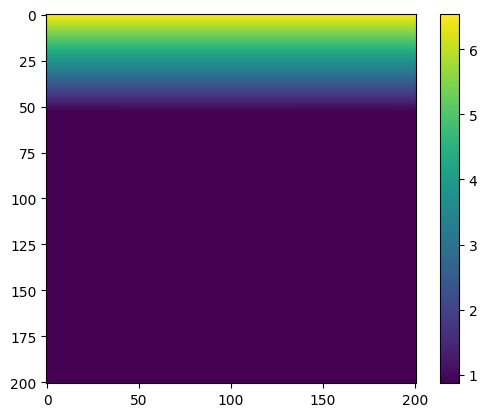

In [33]:
plt.imshow(result_debm["melt_rate"][0] * debm.seconds_per_year() * 52)
plt.colorbar()

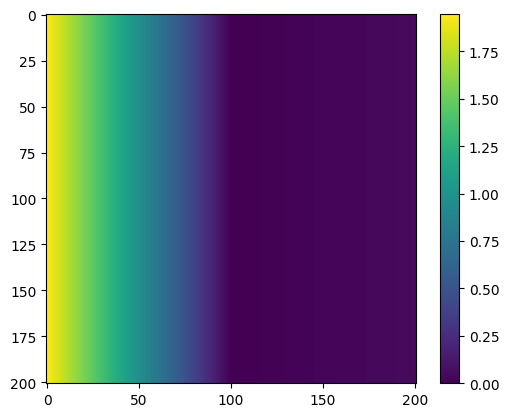

In [34]:
plt.imshow(result_ref["prec"][0])
plt.colorbar()

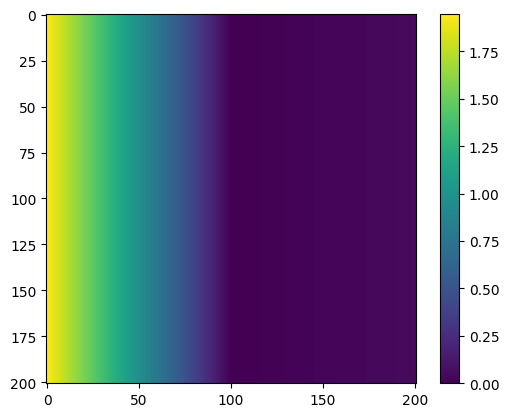

In [35]:
plt.imshow(result_debm["precipitation"][0])
plt.colorbar()

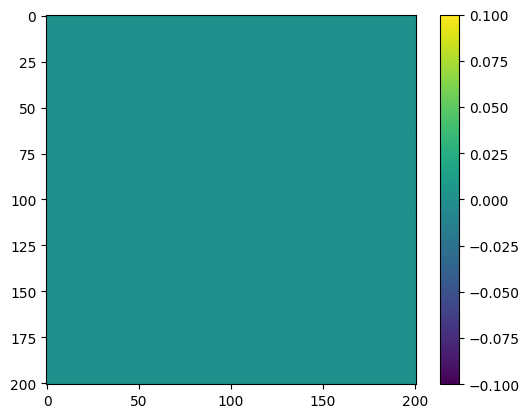

In [36]:
snow_acc = pdd_ref.accumulation_rate(result_debm["temperature"][0], result_debm["precipitation"][0])
plt.imshow(snow_acc)
plt.colorbar()

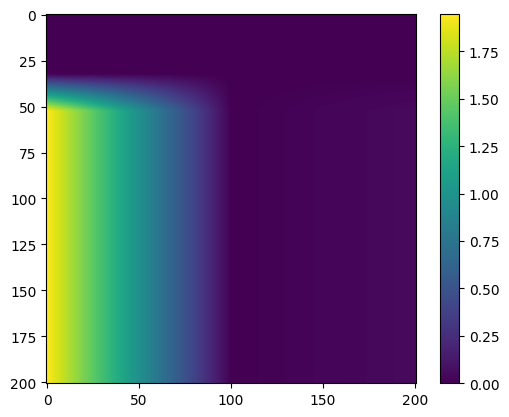

In [37]:
snow_acc = debm.snow_accumulation(result_debm["temperature"][0], result_debm["precipitation"][0])
plt.imshow(snow_acc)
plt.colorbar()

In [38]:
result_debm["temperature"][0, 0, 0], result_debm["precipitation"][0, 0, 0]

(278.4076326810397, 1.9484713260944073)

In [39]:
pdd_ref.accumulation_rate(result_debm["temperature"][0, 0, 0], result_debm["precipitation"][0, 0, 0])

0.0

In [40]:
debm.snow_accumulation(result_debm["temperature"][0, 0, 0], result_debm["precipitation"][0, 0, 0])

0.0

In [41]:
T = np.array([-10, -5, 0, 1, 4, 8])
P = np.array([10, 0.2, 1.0, 0.2, 0.1, 0.4])

In [42]:
pdd_ref.accumulation_rate(T, P)

array([10. ,  0.2,  1. ,  0.1,  0. ,  0. ])

In [43]:
debm.snow_accumulation(T+273.15, P)

array([10. ,  0.2,  1. ,  0.1,  0. ,  0. ])

In [44]:
result_debm["snow_depth"][1]

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [3.9690828 , 3.92939199, 3.88970121, ..., 0.03029887, 0.03060804,
        0.03091722],
       [3.9690828 , 3.92939199, 3.88970121, ..., 0.03029887, 0.03060804,
        0.03091722],
       [3.9690828 , 3.92939199, 3.88970121, ..., 0.03029887, 0.03060804,
        0.03091722]])

In [48]:
result_ref["melt_rate"][1] / result_debm["melt_rate"][1] / debm.seconds_per_year()

array([[118.45745352, 118.45745352, 118.45745352, ..., 118.45745352,
        118.45745352, 118.45745352],
       [118.08371745, 118.08371745, 118.08371745, ..., 118.08371745,
        118.08371745, 118.08371745],
       [117.69746835, 117.69746835, 117.69746835, ..., 117.69746835,
        117.69746835, 117.69746835],
       ...,
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ]])

In [46]:
result_debm["melt_rate"][1]

array([[3.98881874e-09, 3.98881874e-09, 3.98881874e-09, ...,
        3.98881874e-09, 3.98881874e-09, 3.98881874e-09],
       [3.92303079e-09, 3.92303079e-09, 3.92303079e-09, ...,
        3.92303079e-09, 3.92303079e-09, 3.92303079e-09],
       [3.85723513e-09, 3.85723513e-09, 3.85723513e-09, ...,
        3.85723513e-09, 3.85723513e-09, 3.85723513e-09],
       ...,
       [5.29735415e-10, 5.29735415e-10, 5.29735415e-10, ...,
        5.29735415e-10, 5.29735415e-10, 5.29735415e-10],
       [5.29735415e-10, 5.29735415e-10, 5.29735415e-10, ...,
        5.29735415e-10, 5.29735415e-10, 5.29735415e-10],
       [5.29735415e-10, 5.29735415e-10, 5.29735415e-10, ...,
        5.29735415e-10, 5.29735415e-10, 5.29735415e-10]])